In [1]:
"""Example showing the optimization and evolution of surrogates"""

# Copyright (c) 2025 Alliance for Sustainable Energy, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__version__ = "0.5.2"
__deprecated__ = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d(x, y, FX, bounds, label):
    fig, ax = plt.subplots()
    im = ax.imshow(FX, cmap="jet", extent=[bounds[0][0],bounds[0][1],bounds[1][1],bounds[1][0]])
    fig.colorbar(im, ax=ax, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.scatter(x[0:len(x)-1],y[0:len(x)-1],c='gray',marker='x')
    ax.scatter(x[-1],y[-1],c='w',marker='x')
    return fig, ax

In [3]:
def ackley(x, n: int = 2):
    from math import exp, sqrt, pi

    a = 20
    b = 0.2
    c = 2*pi
    return (
        -a * exp(-b * sqrt(np.dot(x, x) / n))
        - exp(np.sum(np.cos(c * np.asarray(x))) / n)
        + a
        + exp(1)
    )


def eggholder(x):
    return -(x[1]+47)*np.sin(np.sqrt(abs(x[1]+0.5*x[0]+47)))-x[0]*np.sin(np.sqrt(abs(x[0]-(x[1]+47))))

def quadratic(x):
    return (x[0] - 500)**2 + (x[1] - 2875)**2

objf = {}
# Breaks the symmetry of the problem
objf["ackley"] = lambda x: ackley([xi - 3.14 for xi in x], n=2)
objf["eggholder"] = eggholder
objf["quadratic"] = quadratic

refbounds = {}
refbounds["ackley"] = [-32.768, 32.768]
refbounds["eggholder"] = [-512, 512]
refbounds["quadratic"] = [0, 10000]

In [4]:
# Define dimensions and bounds
n = 2
funcstr = "ackley"
bounds = [refbounds[funcstr]] * n

In [5]:
# Compute the mean and standard deviation of the GP
nx = 100
ny = 100
x = np.linspace(bounds[0][0], bounds[0][1], nx)
y = np.linspace(bounds[1][0], bounds[1][1], ny)
XY = np.array([[[x[j], y[i]] for j in range(nx)] for i in range(ny)])

In [6]:
import blackboxopt.optimize as bbopt
from blackboxopt.gp import GaussianProcess
from blackboxopt.acquisition import TargetValueAcquisition, expected_improvement
from blackboxopt.rbf import RbfModel, MedianLpfFilter
from sklearn.gaussian_process.kernels import RBF as GPkernelRBF
from scipy.linalg import ldl

savefig=False

def callback_rbf(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = RbfModel()
        model.reserve(0, n)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        S = np.zeros((ny,nx))
        for i in range(ny):
            S[i, :], _ = model(XY[i, :])

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], S, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

def callback_cptv(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    model = RbfModel()
    model.reserve(0, n)
    model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

    S = np.zeros((ny,nx))
    for i in range(ny):
        S[i, :], _ = model(XY[i, :])

    plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], S, bounds, "s(x,y)")
    if savefig:
        plt.savefig("surrogate_{:03d}.png".format(out.nfev))
    plt.show()

def callback_rbf_tv(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = RbfModel(filter=MedianLpfFilter())
        model.reserve(0, n)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        S = np.zeros((ny,nx))
        MuMeas = np.zeros((ny,nx))
        LDLt = ldl(model.get_RBFmatrix())
        for i in range(ny):
            S[i, :], _ = model(XY[i, :])
            MuMeas[i, :] = TargetValueAcquisition.mu_measure(model, XY[i, :], LDLt)
        Gxmin = MuMeas * (S - 0)**2
        Gxmin[Gxmin > 1] = 1
        sqrtGxmin = np.sqrt(MuMeas) * np.absolute(S - 0)
        sqrtGxmin[sqrtGxmin > 1] = 1

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], S, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], np.log(MuMeas), bounds, "log(muMeas(x,y))")
        if savefig:
            plt.savefig("logMuMeas_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], Gxmin, bounds, r"$g_{xmin}(x,y)$")
        if savefig:
            plt.savefig("gxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], np.log(Gxmin), bounds, r"$log(g_{xmin}(x,y))$")
        if savefig:
            plt.savefig("logGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], sqrtGxmin, bounds, r"$\sqrt{g_{xmin}(x,y)}$")
        if savefig:
            plt.savefig("sqrtGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], -1/Gxmin, bounds, r"$-1/g_{xmin}(x,y)$")
        if savefig:
            plt.savefig("minusOneOverGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

def callback_gp(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = GaussianProcess(GPkernelRBF(), n_restarts_optimizer=20, normalize_y=True)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        Mean = np.zeros((ny,nx))
        Std = np.zeros((ny,nx))
        EI = np.zeros((ny,nx))
        for i in range(ny):
            Mean[i, :], Std[i, :] = model(XY[i, :])
            EI[i, :] = expected_improvement(Mean[i, :], Std[i, :], out.fx)

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], Mean, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], EI, bounds, "EI(x,y)")
        if savefig:
            plt.savefig("EI_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

Best value of  0.0032736616095481175  at  [3.13891623 3.13963036]
Last sample point at  [3.15675419 3.13963036]


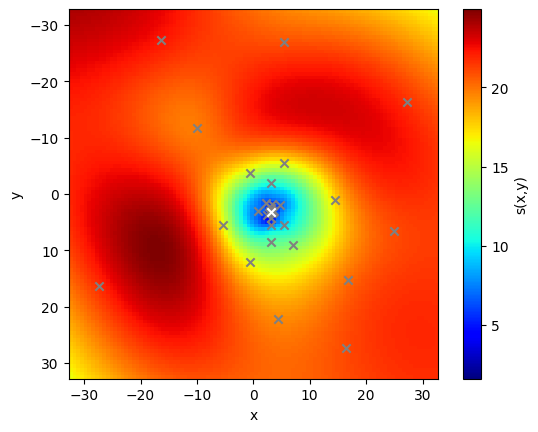

Best value of  0.0032736616095481175  at  [3.13891623 3.13963036]
Last sample point at  [ 3.44080182 32.76799879]


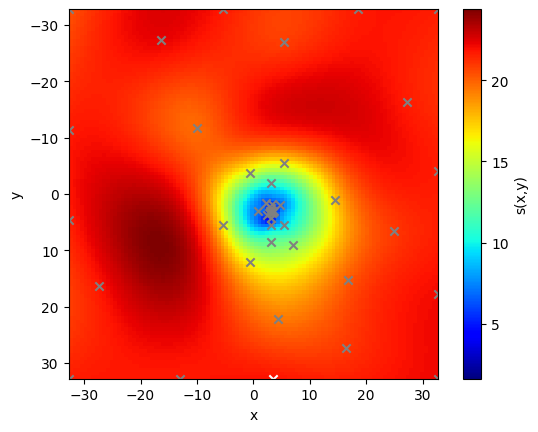

Best value of  0.00029394237173407944  at  [3.1401025  3.13998347]
Last sample point at  [3.1401025  3.30462017]


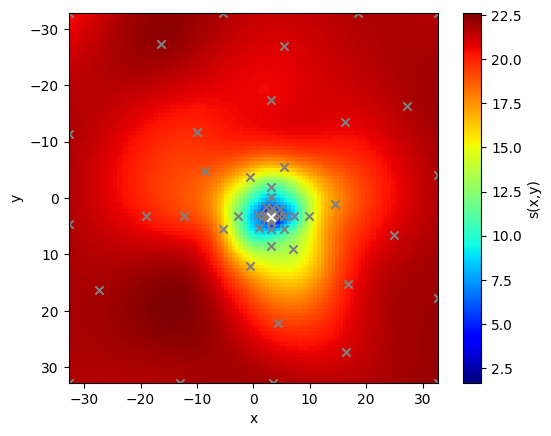

Best value of  0.00029394237173407944  at  [3.1401025  3.13998347]
Last sample point at  [3.13972707 3.13930136]


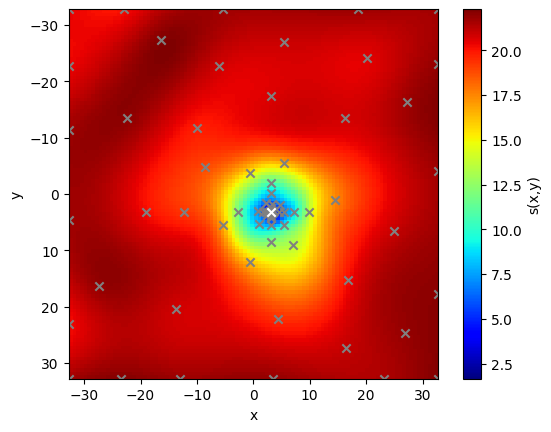

OptimizeResult(x=array([3.1401025 , 3.13998347]), fx=0.00029394237173407944, nit=4, nfev=100, sample=array([[-27.30666667,  16.384     ],
       [-16.384     , -27.30666667],
       [ -5.46133333,   5.46133333],
       [  5.46133333,  -5.46133333],
       [ 16.384     ,  27.30666667],
       [ 27.30666667, -16.384     ],
       [ 24.95409099,   6.51019347],
       [-10.02933519, -11.70424058],
       [  5.40951351,   5.46133333],
       [  6.94624052,   9.06593285],
       [  5.40951351, -26.90675971],
       [ 14.44335867,   1.13665944],
       [  3.61866745,   2.94813795],
       [  2.16123264,   1.67419701],
       [  4.32660018,  22.18172773],
       [ 16.77166979,  15.20355019],
       [  4.7056807 ,   2.01295451],
       [  2.4538466 ,   3.79040949],
       [ -0.65255053,  11.98743865],
       [ -0.56152083,  -3.63799355],
       [  3.12822719,   2.94813795],
       [  2.89992581,   2.94813795],
       [  3.12822719,  -2.00465311],
       [  3.12822719,   8.51125924],
       [  3

In [7]:
np.random.seed(3)

callback = {
    "bayesian_optimization":callback_gp,
    "cptv":callback_cptv,
    "cptvl":callback_cptv,
    "surrogate_optimization":callback_rbf_tv,
    "multistart_msrs":callback_rbf,
    "dycors":callback_rbf
}
methodstr = "cptv"

getattr(bbopt, methodstr)(lambda x: [objf[funcstr](xi) for xi in x], bounds=bounds, maxeval=100, callback=callback[methodstr])